<a href="https://colab.research.google.com/github/AndrzejOlejniczak/PORTFOLIO/blob/main/Udemy_PyTorch_04_easier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Computer vision with PyTorch
## FashionMNIST: few models' evaluation.

## 0. Set up the envrionment

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

In [ ]:
from matplotlib.ticker import MaxNLocator


In [ ]:
print(torch.__version__ + '\n' + torchvision.__version__)

2.1.0+cu118
0.16.0+cu118


In [ ]:
SEED = 44

In [ ]:
DEVICE= 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
from timeit import default_timer as timer
from tqdm.auto import tqdm

In [ ]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 8.7 MB/s eta 0:00:00


In [ ]:
from torchmetrics.classification import MulticlassAccuracy

In [ ]:
from torchmetrics import ConfusionMatrix

In [ ]:
from mlxtend.plotting import plot_confusion_matrix

### 0.1. Helper functions

In [ ]:
# Training loop execution timing function
def print_train_time(
    start: float,
    end: float,
    device: torch.device
):
  total_time = end - start
  print(f'Train time on {device}: {total_time:.4f}')
  return

In [ ]:
type(DEVICE)

str

In [ ]:
def eval_model(
    model: torch.nn.Module,
    data_loader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    device: str,
    accuracy_fn,
):
  '''Returns a dictionary conatining the results o model predicting on data_loader.

  Args:
    model (torch.nn.Module): A PyTorch model
    data_loader (torch.utils.data.DataLoader): The target dataset to predict on
    loss_fn (torch.nn.Module): The loss function of model.
    device: Device on which tensor operations are performed
    accuracy_fn: An accuracy metric

  Returns:
    (dict): results of model making predictions on data_loader
  '''

  loss, acc = 0, 0

  model.eval()
  with torch.inference_mode():
    for X, y in data_loader:
      X, y = X.to(device), y.to(device)

      # make predictions
      y_pred = model(X)

      # Compute and accumulate loss and metric values per batch
      loss += loss_fn(y_pred, y)
      acc += accuracy_fn(preds=y_pred, target=y)

    loss /= len(data_loader)
    acc /= len(data_loader)

    return {
        'model_name': model.__class__.__name__,
        'model_loss': loss.item(),
        'model_acc': acc.item()
    }

In [ ]:
def plot_history(
    train_loss_arr: list,
    train_acc_arr: list,
    test_loss_arr: list,
    test_acc_arr: list,
    model: torch.nn.Module,
):
  '''Accepts list of tensors. Transforms them into plain lists and plots lineplots.'''

  train_loss_arr = (torch.Tensor(train_loss_arr).to('cpu').tolist())
  train_acc_arr = (torch.Tensor(train_acc_arr).to('cpu').tolist())
  test_loss_arr = (torch.Tensor(test_loss_arr).to('cpu').tolist())
  test_acc_arr = (torch.Tensor(test_acc_arr).to('cpu').tolist())

  fig, axs = plt.subplots(1, 2, figsize=(12, 6))

  # Create loss axis
  ax = axs[0]
  ax.xaxis.set_major_locator(MaxNLocator(integer=True))

  ax.plot(train_loss_arr, label='Train loss', marker='o')

  ax.plot(test_loss_arr, label='Test loss', marker='o')


  ax.legend()
  ax.set_title(f'{model.__class__.__name__} loss per epoch')
  ax.set_xlabel('Epoch')

  # Create accuracy axis
  ax = axs[1]
  ax.xaxis.set_major_locator(MaxNLocator(integer=True))

  ax.plot(train_acc_arr, label='Train accuracy', marker='o')

  ax.plot(test_acc_arr, label='Test accuracy', marker='o')

  ax.legend()
  ax.set_title(f'{model.__class__.__name__} accuracy per epoch')
  ax.set_xlabel('Epoch')

  plt.show()

## 1. Download and prepare the data



### 1.1. Download the data

In [ ]:

# Train data
train_data = datasets.FashionMNIST(
    root='data',
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

In [ ]:
# Test data
test_data = datasets.FashionMNIST(
    root='data',
    train=False,
    download=True,
    transform=ToTensor()
)

### 1.2. Inspect the data

In [ ]:
image, label = train_data[0]

9


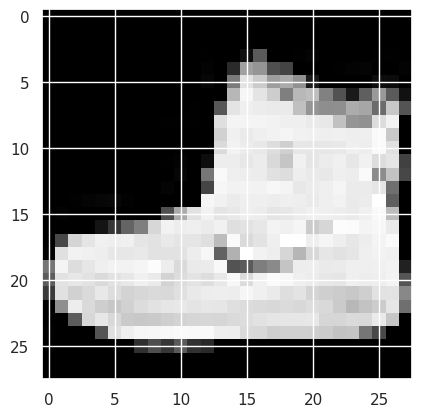

In [ ]:
print(label)
plt.imshow(image.squeeze(), cmap='Greys_r')

In [ ]:
class_names = train_data.classes
print(class_names)

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [ ]:
classes_dct = dict(zip(range(len(class_names)), class_names))
print(classes_dct)

{0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat', 5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'}


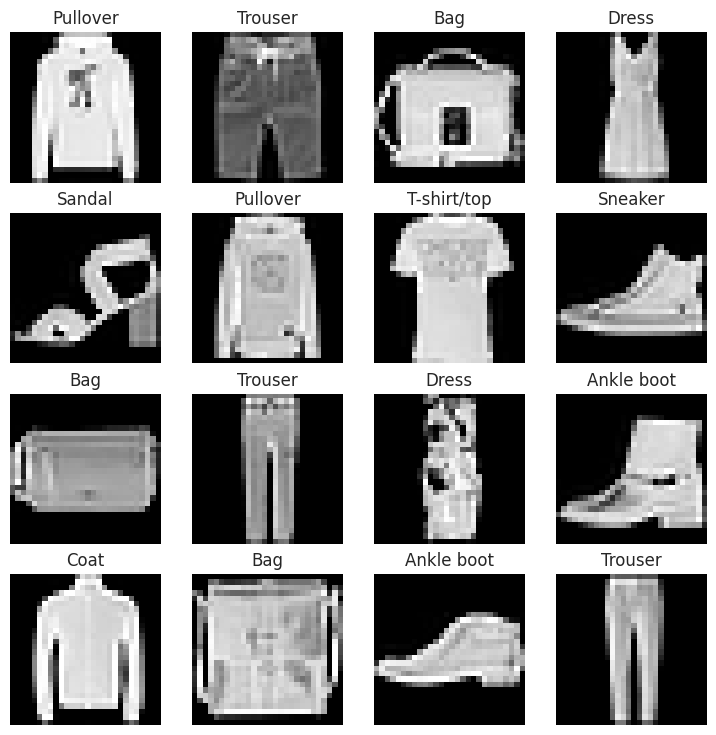

In [ ]:
# Show random sample from the dataset
torch.manual_seed(SEED)
fig = plt.figure(figsize=(9,9))
rows, cols = 4, 4

for i in range(1, rows*cols+1):
  random_idx = torch.randint(0, len(train_data), size=[1]).item()
  img, label = train_data[random_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(img.squeeze(), cmap='gray')
  plt.title(class_names[label])
  plt.axis(False)

### 1.3. Prepare DataLoaders

In [ ]:
BATCH_SIZE = 32

In [ ]:



# Train data loader
train_dataloader = DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    shuffle=True
)

In [ ]:
# Test data loader
test_dataloader = DataLoader(
    test_data,
    batch_size=BATCH_SIZE,
    shuffle=False
)

In [ ]:
print(len(train_dataloader), len(test_dataloader))

1875 313


In [ ]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))

In [ ]:
print(train_features_batch.shape, train_labels_batch.shape)

torch.Size([32, 1, 28, 28]) torch.Size([32])


## 2. Model 0: the baseline model

### 2.1. Build the model class and instantiate the model

In [ ]:
class FMNST_Model_0(nn.Module):
  def __init__(
      self,
      input_shape: int,
      hidden_units: int,
      output_shape: int
  ):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input_shape, out_features=hidden_units),
        nn.Linear(in_features=hidden_units, out_features=output_shape)
    )

  def forward(self, x): return self.layer_stack(x)

In [ ]:
torch.manual_seed(SEED)

model_0 = FMNST_Model_0(
    input_shape = 784,
    hidden_units = 10,
    output_shape=len(class_names)
).to(DEVICE)

### 2.2. Set up hyperparameters, metric, loss function and optimizer

In [ ]:
LEARNING_RATE = 0.01
EPOCHS = 20

In [ ]:
# Loss function
loss_fn = nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.SGD(
    params=model_0.parameters(), lr=LEARNING_RATE
)

# Metric
metric_fn = MulticlassAccuracy(
    num_classes=len(class_names)
).to(DEVICE)

### 2.3. Create training loop

In [ ]:
model_0_train_loss = []
model_0_train_acc = []

model_0_test_loss = []
model_0_test_acc = []

In [ ]:
# Set the seed
torch.manual_seed(SEED)

# Start the timer
time_start = timer()

# Create training and testing loop
for epoch in tqdm(range(EPOCHS)):
  print(f'Epoch: {epoch}')

  ### Training
  train_loss = 0
  train_acc = 0

  # Loop through batches
  for batch, (X, y) in enumerate(train_dataloader):
    X, y = X.to(DEVICE), y.to(DEVICE)
    model_0.train()

    # 1. Forward pass
    y_pred = model_0(X)

    # 2. Calculate batch loss
    loss = loss_fn(y_pred, y) # CrossEntropyLoss accepts logits
    train_loss += loss

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    if batch % 200 == 0:
      print(f'Batch {batch} was processed')

    # Compute metric for batch
    train_acc += metric_fn(preds=y_pred, target=y)

  # Compute train loss for epoch
  train_loss /= len(train_dataloader)
  model_0_train_loss.append(train_loss)

  # Compute train accuracy for epoch
  train_acc /= len(train_dataloader)
  model_0_train_acc.append(train_acc)

  ### Testing
  test_loss, test_acc = 0, 0

  model_0.eval()
  with torch.inference_mode():
    for X, y in test_dataloader:
      X, y = X.to(DEVICE), y.to(DEVICE)

      # 1. Forward pass
      test_pred = model_0(X)

      # 2. Calculate loss
      test_loss += loss_fn(test_pred, y)

      # 3. Calculate accuracy
      test_acc += metric_fn(preds=test_pred, target=y)

    test_loss /= len(test_dataloader)
    test_acc /= len(test_dataloader)

    model_0_test_loss.append(test_loss)
    model_0_test_acc.append(test_acc)

  print(f'Epoch {epoch} metrics:' + '\n' + f'train_loss: {train_loss:.4f} | train_acc: {train_acc:.4f} | test_loss: {test_loss:.4f} | test_acc: {test_acc:.4f}')

# Calculate training time
time_stop = timer()
model_0_train_time = print_train_time(
    start = time_start,
    end = time_stop,
    device=DEVICE,
)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0
Batch 0 was processed
Batch 200 was processed
Batch 400 was processed
Batch 600 was processed
Batch 800 was processed
Batch 1000 was processed
Batch 1200 was processed
Batch 1400 was processed
Batch 1600 was processed
Batch 1800 was processed
Epoch 0 metrics:
train_loss: 0.9112 | train_acc: 0.6781 | test_loss: 0.6485 | test_acc: 0.7676
Epoch: 1
Batch 0 was processed
Batch 200 was processed
Batch 400 was processed
Batch 600 was processed
Batch 800 was processed
Batch 1000 was processed
Batch 1200 was processed
Batch 1400 was processed
Batch 1600 was processed
Batch 1800 was processed
Epoch 1 metrics:
train_loss: 0.5679 | train_acc: 0.7965 | test_loss: 0.5517 | test_acc: 0.8002
Epoch: 2
Batch 0 was processed
Batch 200 was processed
Batch 400 was processed
Batch 600 was processed
Batch 800 was processed
Batch 1000 was processed
Batch 1200 was processed
Batch 1400 was processed
Batch 1600 was processed
Batch 1800 was processed
Epoch 2 metrics:
train_loss: 0.5047 | train_acc: 0.814

### 2.4. Evaluate model 0

In [ ]:
model_0_train_loss

[tensor(0.9112, grad_fn=<DivBackward0>),
 tensor(0.5679, grad_fn=<DivBackward0>),
 tensor(0.5047, grad_fn=<DivBackward0>),
 tensor(0.4770, grad_fn=<DivBackward0>),
 tensor(0.4599, grad_fn=<DivBackward0>),
 tensor(0.4484, grad_fn=<DivBackward0>),
 tensor(0.4389, grad_fn=<DivBackward0>),
 tensor(0.4318, grad_fn=<DivBackward0>),
 tensor(0.4270, grad_fn=<DivBackward0>),
 tensor(0.4220, grad_fn=<DivBackward0>),
 tensor(0.4186, grad_fn=<DivBackward0>),
 tensor(0.4151, grad_fn=<DivBackward0>),
 tensor(0.4120, grad_fn=<DivBackward0>),
 tensor(0.4094, grad_fn=<DivBackward0>),
 tensor(0.4075, grad_fn=<DivBackward0>),
 tensor(0.4052, grad_fn=<DivBackward0>),
 tensor(0.4032, grad_fn=<DivBackward0>),
 tensor(0.4016, grad_fn=<DivBackward0>),
 tensor(0.3998, grad_fn=<DivBackward0>),
 tensor(0.3990, grad_fn=<DivBackward0>)]

In [ ]:
model_0_eval_dct = eval_model(model=model_0, data_loader=test_dataloader, loss_fn=loss_fn, device=DEVICE, accuracy_fn=metric_fn)

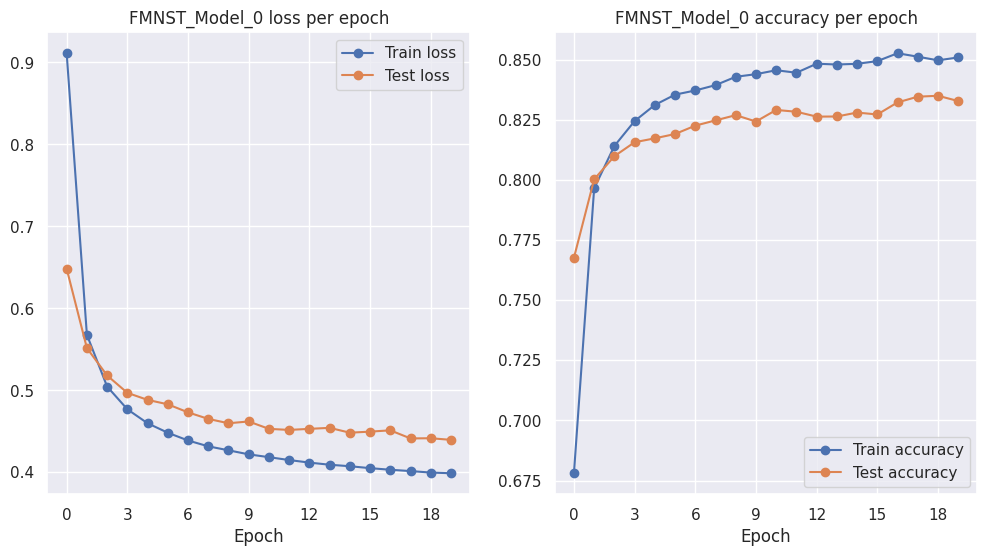

In [ ]:
plot_history(
  model_0_train_loss,
  model_0_train_acc,
  model_0_test_loss,
  model_0_test_acc,
  model_0
)

---

Model 0 is visibly overfitting on the data.

---

## 3. Model 1: DNN with nonlinearity

### 3.1. Build the model class and instantiate a model

In [ ]:
class FMNST_Model_1(nn.Module):
  def __init__(
      self,
      input_shape: int,
      hidden_units: int,
      output_shape: int,
      n_layers: int,
  ):
    super().__init__()

    self.input_shape = input_shape
    self.hidden_units = hidden_units
    self.output_shape = output_shape
    self.n_layers = n_layers

    self.input_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=self.input_shape, out_features=self.hidden_units),
        nn.ReLU(),
    )
    self.hidden_stack= nn.Sequential()
    for it in range(self.n_layers):
      self.hidden_stack.append(nn.Linear(in_features=self.hidden_units, out_features=self.hidden_units))
      self.hidden_stack.append(nn.ReLU())

    self.output_stack = nn.Sequential(
        nn.Linear(in_features=hidden_units, out_features=output_shape),
        nn.ReLU()
    )

  def forward(self, x: torch.Tensor):
    x = self.input_stack(x)
    if self.n_layers > 0:
      x = self.hidden_stack(x)
    x = self.output_stack(x)

    return x


In [ ]:
torch.manual_seed(SEED)

model_1_0 = FMNST_Model_1(
    input_shape=784,
    hidden_units=10,
    output_shape=len(class_names),
    n_layers=0
).to(DEVICE)

### 3.2. Set up metric, loss function and optimizer

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1_0.parameters(), lr=LEARNING_RATE)

In [ ]:
# Metric
metric_fn = MulticlassAccuracy(
    num_classes=len(class_names)
).to(DEVICE)

### 3.3. Create functions for train and test steps

In [ ]:
def train_step(
  model: torch.nn.Module,
  data_loader: torch.utils.data.DataLoader,
  loss_fn: torch.nn.Module,
  optimizer: torch.optim.Optimizer,
  metric_fn,
  device: torch.device
):
  '''Performs a trainig step'''
  train_loss, train_acc = 0.0, 0.0

  # Set model to training mode
  model.train()

  # Loop through batches
  for batch, (X, y) in enumerate(data_loader):
    # Send data to device
    X, y = X.to(device), y.to(device)

    # 1. Forward pass
    y_pred = model(X)

    # 2. Calculate batch loss
    loss = loss_fn(y_pred, y)

    train_loss += loss
    train_acc += metric_fn(preds=y_pred, target=y)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backpropagation
    loss.backward()

    # Apply gradient clipping (from other project)
    '''
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=.001, error_if_nonfinite=False)  # Adjust max_norm as needed
    '''

    # 5. Optimizer step
    optimizer.step()

  # Compute and show metrics
  train_loss /= len(data_loader)
  train_acc /= len(data_loader)

  print(f'Loss: {train_loss:.5f} Acc: {train_acc:.4f}')

  return train_loss, train_acc

In [ ]:
def test_step(
  model: torch.nn.Module,
  data_loader: torch.utils.data.DataLoader,
  loss_fn: torch.nn.Module,
  metric_fn,
  device: torch.device
):
  with torch.inference_mode():
    model.eval()

    test_loss, test_acc = 0.0, 0.0

    for X, y in data_loader:
      # Send data to device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      y_pred = model(X)

      # 2. Calculate batch loss
      loss = loss_fn(y_pred, y)
      test_loss += loss
      test_acc += metric_fn(preds=y_pred, target=y)

    # Compute and show metrics
    test_loss /= len(data_loader)
    test_acc /= len(data_loader)

    print(f'Loss: {test_loss:.5f} Acc: {test_acc:.4f}')

  return test_loss, test_acc

In [ ]:
print(SEED, EPOCHS, LEARNING_RATE, DEVICE)

44 20 0.01 cpu


### 3.4. Create training loop

In [ ]:
torch.manual_seed(SEED)
start_time = timer()

model_1_0_train_loss_history = []
model_1_0_train_acc_history = []
model_1_0_test_loss_history = []
model_1_0_test_acc_history = []

for epoch in tqdm(range(EPOCHS)):
  print(f'Starting epoch: {epoch}')

  # perform training step
  train_loss, train_acc = train_step(
      model=model_1_0,
      data_loader=train_dataloader,
      loss_fn=loss_fn,
      optimizer=optimizer,
      metric_fn=metric_fn,
      device=DEVICE
  )

  # perform testing step
  test_loss, test_acc = test_step(
      model=model_1_0,
      data_loader=test_dataloader,
      loss_fn=loss_fn,
      metric_fn=metric_fn,
      device=DEVICE
  )

  # Append metric history lists
  model_1_0_train_loss_history.append(train_loss)
  model_1_0_train_acc_history.append(train_acc)
  model_1_0_test_loss_history.append(test_loss)
  model_1_0_test_acc_history.append(test_acc)

end_time = timer()
model_1_0_train_time = print_train_time(
    start=start_time,
    end=end_time,
    device=DEVICE
)

  0%|          | 0/20 [00:00<?, ?it/s]

Starting epoch: 0
Loss: 1.47463 Acc: 0.4934
Loss: 1.19637 Acc: 0.5765
Starting epoch: 1
Loss: 1.11954 Acc: 0.5962
Loss: 1.08741 Acc: 0.6050
Starting epoch: 2
Loss: 1.05198 Acc: 0.6084
Loss: 1.05581 Acc: 0.6089
Starting epoch: 3
Loss: 1.02534 Acc: 0.6153
Loss: 1.03232 Acc: 0.6127
Starting epoch: 4
Loss: 1.00981 Acc: 0.6188
Loss: 1.02163 Acc: 0.6139
Starting epoch: 5
Loss: 0.99926 Acc: 0.6204
Loss: 1.01192 Acc: 0.6169
Starting epoch: 6
Loss: 0.99119 Acc: 0.6232
Loss: 1.01781 Acc: 0.6155
Starting epoch: 7
Loss: 0.98491 Acc: 0.6241
Loss: 1.00574 Acc: 0.6202
Starting epoch: 8
Loss: 0.98031 Acc: 0.6273
Loss: 1.00188 Acc: 0.6216
Starting epoch: 9
Loss: 0.97604 Acc: 0.6251
Loss: 1.00038 Acc: 0.6184
Starting epoch: 10
Loss: 0.97223 Acc: 0.6272
Loss: 0.99361 Acc: 0.6234
Starting epoch: 11
Loss: 0.96926 Acc: 0.6290
Loss: 0.99486 Acc: 0.6253
Starting epoch: 12
Loss: 0.96669 Acc: 0.6291
Loss: 0.98871 Acc: 0.6254
Starting epoch: 13
Loss: 0.96423 Acc: 0.6296
Loss: 0.99095 Acc: 0.6227
Starting epoch: 

### 3.5. Evaluate model 1_0

In [ ]:
model_1_0_eval_dct = eval_model(model=model_1_0, data_loader=test_dataloader, loss_fn=loss_fn, device=DEVICE, accuracy_fn=metric_fn)

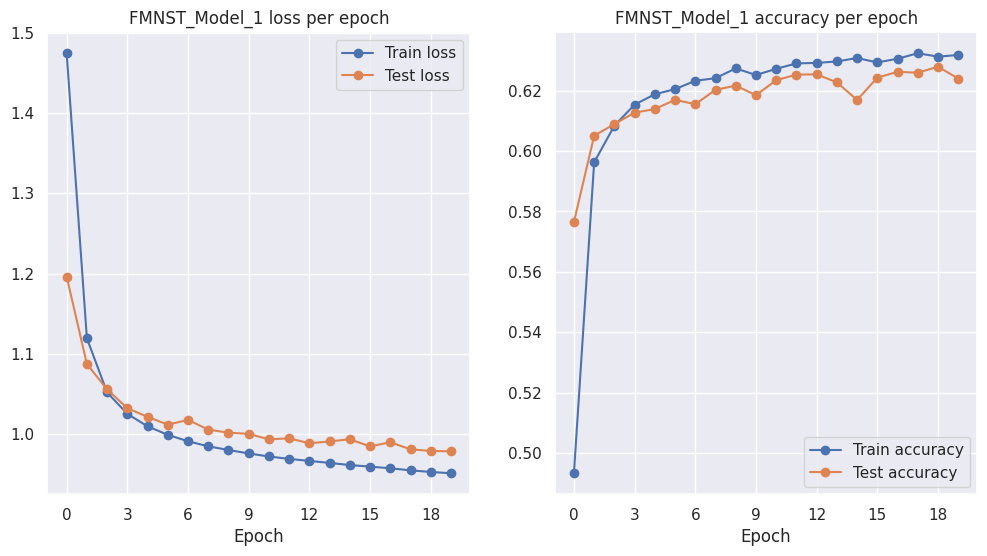

In [ ]:
plot_history(
    model_1_0_train_loss_history,
    model_1_0_train_acc_history,
    model_1_0_test_loss_history,
    model_1_0_test_acc_history,
    model_1_0
)

### 3.6. Repeat the experiment, incresing the depth of linear model

In [ ]:
N_LAYERS = 2

In [ ]:
torch.manual_seed(SEED)

model_1_1 = FMNST_Model_1(
    input_shape=784,
    hidden_units=10,
    output_shape=len(class_names),
    n_layers=N_LAYERS
).to(DEVICE)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1_1.parameters(), lr=LEARNING_RATE)

In [ ]:
metric_fn = MulticlassAccuracy(
    num_classes=len(class_names)
).to(DEVICE)

In [ ]:
torch.manual_seed(SEED)
start_time = timer()

model_1_1_train_loss_history = []
model_1_1_train_acc_history = []
model_1_1_test_loss_history = []
model_1_1_test_acc_history = []

for epoch in tqdm(range(EPOCHS)):
  print(f'Starting epoch: {epoch}')

  # perform training step
  train_loss, train_acc = train_step(
      model=model_1_1,
      data_loader=train_dataloader,
      loss_fn=loss_fn,
      optimizer=optimizer,
      metric_fn=metric_fn,
      device=DEVICE
  )

  # perform testing step
  test_loss, test_acc = test_step(
      model=model_1_1,
      data_loader=test_dataloader,
      loss_fn=loss_fn,
      metric_fn=metric_fn,
      device=DEVICE
  )

  # Append metric history lists
  model_1_1_train_loss_history.append(train_loss)
  model_1_1_train_acc_history.append(train_acc)
  model_1_1_test_loss_history.append(test_loss)
  model_1_1_test_acc_history.append(test_acc)

end_time = timer()
model_1_1_train_time = print_train_time(
    start=start_time,
    end=end_time,
    device=DEVICE
)

  0%|          | 0/20 [00:00<?, ?it/s]

Starting epoch: 0
Loss: 1.93711 Acc: 0.3327
Loss: 1.46649 Acc: 0.5065
Starting epoch: 1
Loss: 1.22632 Acc: 0.5609
Loss: 1.10454 Acc: 0.5955
Starting epoch: 2
Loss: 1.04958 Acc: 0.6239
Loss: 1.02622 Acc: 0.6283
Starting epoch: 3
Loss: 0.98517 Acc: 0.6556
Loss: 0.97747 Acc: 0.6608
Starting epoch: 4
Loss: 0.93626 Acc: 0.6708
Loss: 0.94404 Acc: 0.6794
Starting epoch: 5
Loss: 0.90290 Acc: 0.6798
Loss: 0.90685 Acc: 0.6796
Starting epoch: 6
Loss: 0.87805 Acc: 0.6845
Loss: 0.90584 Acc: 0.6801
Starting epoch: 7
Loss: 0.86151 Acc: 0.6860
Loss: 0.88782 Acc: 0.6792
Starting epoch: 8
Loss: 0.84851 Acc: 0.6899
Loss: 0.88126 Acc: 0.6850
Starting epoch: 9
Loss: 0.83694 Acc: 0.6924
Loss: 0.86296 Acc: 0.6843
Starting epoch: 10
Loss: 0.82689 Acc: 0.6961
Loss: 0.85703 Acc: 0.6905
Starting epoch: 11
Loss: 0.81742 Acc: 0.6961
Loss: 0.85576 Acc: 0.6877
Starting epoch: 12
Loss: 0.81156 Acc: 0.6992
Loss: 0.83801 Acc: 0.6928
Starting epoch: 13
Loss: 0.80521 Acc: 0.6973
Loss: 0.86209 Acc: 0.6919
Starting epoch: 

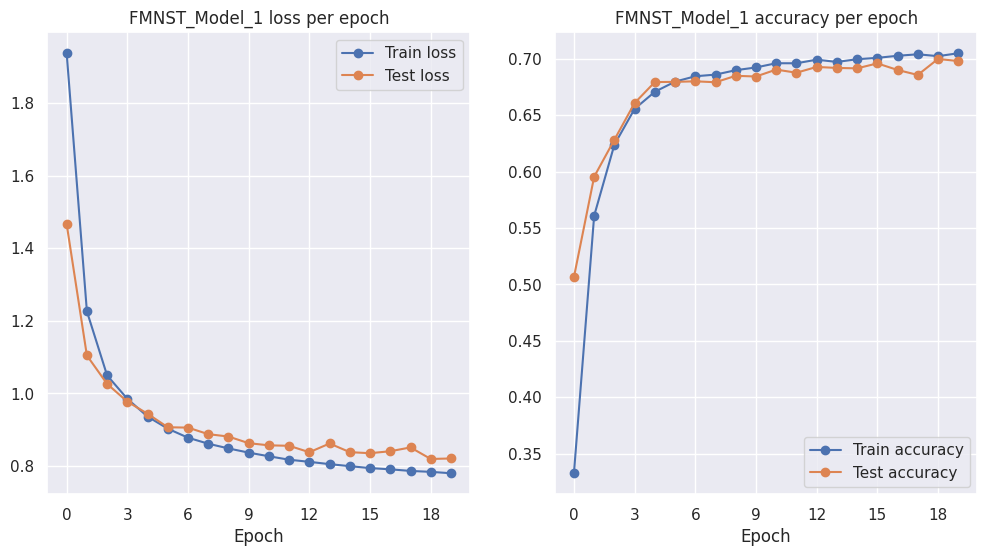

In [ ]:
plot_history(
    model_1_1_train_loss_history,
    model_1_1_train_acc_history,
    model_1_1_test_loss_history,
    model_1_1_test_acc_history,
    model_1_1
)

In [ ]:
model_1_1_eval_dct = eval_model(model=model_1_1, data_loader=test_dataloader, loss_fn=loss_fn, device=DEVICE, accuracy_fn=metric_fn)

## 4. Model 2: Convolutional Neural Network

### 4.1. Build model class and instantiate the model

In [ ]:
class FMNST_Model_2(nn.Module):
  '''
  Model architecture copying TinyVGG
  '''
  def __init__(
      self,
      input_shape: int,
      hidden_units: int,
      output_shape: int,
  ):
    super().__init__()
    self.input_shape = input_shape
    self.hidden_units = hidden_units
    self.output_shape = output_shape

    self.input_block = nn.Sequential(
        nn.Conv2d(
            in_channels=self.input_shape,
            out_channels=self.hidden_units,
            kernel_size=3, # how big is the square that's going over the image?
            stride=1, # default
            padding=1
        ),
        nn.ReLU(),
        nn.Conv2d(
            in_channels=self.hidden_units,
            out_channels=self.hidden_units,
            kernel_size=3,
            stride=1,
            padding=1
        ),
        nn.ReLU(),
        nn.MaxPool2d(
            kernel_size=2,
            stride=2
        )
    )

    self.middle_block = nn.Sequential(
        nn.Conv2d(
            in_channels=self.hidden_units,
            out_channels=self.hidden_units,
            kernel_size=3, # how big is the square that's going over the image?
            stride=1, # default
            padding=1
        ),
        nn.ReLU(),
        nn.Conv2d(
            in_channels=self.hidden_units,
            out_channels=self.hidden_units,
            kernel_size=3,
            stride=1,
            padding=1
        ),
        nn.ReLU(),
        nn.MaxPool2d(
            kernel_size=2,
            stride=2
        )
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*7*7, out_features=output_shape)
    )

  def forward(self, x: torch.Tensor):
    x = self.input_block(x)
    x = self.middle_block(x)
    x = self.classifier(x)

    return x

In [ ]:
torch.manual_seed(SEED)
model_2 = FMNST_Model_2(
    input_shape=1,
    hidden_units=10,
    output_shape=len(class_names)
).to(DEVICE)

### 4.2. Setup loss, optimizer and metric

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(), lr=LEARNING_RATE)
metric_fn = MulticlassAccuracy(
    num_classes=len(class_names)
  ).to(DEVICE)

### 4.3. Create training loop

In [ ]:
torch.manual_seed(SEED)
start_time = timer()

model_2_train_loss_history = []
model_2_train_acc_history = []
model_2_test_loss_history = []
model_2_test_acc_history = []

for epoch in tqdm(range(EPOCHS)):
  print(f'Starting epoch: {epoch}')

  # perform training step
  train_loss, train_acc = train_step(
      model=model_2,
      data_loader=train_dataloader,
      loss_fn=loss_fn,
      optimizer=optimizer,
      metric_fn=metric_fn,
      device=DEVICE
  )

  # perform testing step
  test_loss, test_acc = test_step(
      model=model_2,
      data_loader=test_dataloader,
      loss_fn=loss_fn,
      metric_fn=metric_fn,
      device=DEVICE
  )

  # Append metric history lists
  model_2_train_loss_history.append(train_loss)
  model_2_train_acc_history.append(train_acc)
  model_2_test_loss_history.append(test_loss)
  model_2_test_acc_history.append(test_acc)

end_time = timer()
model_2_train_time = print_train_time(
    start=start_time,
    end=end_time,
    device=DEVICE
)

  0%|          | 0/20 [00:00<?, ?it/s]

Starting epoch: 0
Loss: 1.07060 Acc: 0.6038
Loss: 0.57365 Acc: 0.7851
Starting epoch: 1
Loss: 0.49810 Acc: 0.8082
Loss: 0.48613 Acc: 0.8179
Starting epoch: 2
Loss: 0.43437 Acc: 0.8312
Loss: 0.44222 Acc: 0.8316
Starting epoch: 3
Loss: 0.40458 Acc: 0.8463
Loss: 0.40831 Acc: 0.8485
Starting epoch: 4
Loss: 0.38322 Acc: 0.8543
Loss: 0.39383 Acc: 0.8501
Starting epoch: 5
Loss: 0.36646 Acc: 0.8620
Loss: 0.37990 Acc: 0.8575
Starting epoch: 6
Loss: 0.35247 Acc: 0.8647
Loss: 0.37738 Acc: 0.8592
Starting epoch: 7
Loss: 0.34062 Acc: 0.8685
Loss: 0.38807 Acc: 0.8502
Starting epoch: 8
Loss: 0.33212 Acc: 0.8735
Loss: 0.35794 Acc: 0.8630
Starting epoch: 9
Loss: 0.32466 Acc: 0.8760
Loss: 0.36059 Acc: 0.8592
Starting epoch: 10
Loss: 0.31821 Acc: 0.8793
Loss: 0.34942 Acc: 0.8661
Starting epoch: 11
Loss: 0.31156 Acc: 0.8800
Loss: 0.34036 Acc: 0.8713
Starting epoch: 12
Loss: 0.30650 Acc: 0.8833
Loss: 0.34398 Acc: 0.8722
Starting epoch: 13
Loss: 0.30257 Acc: 0.8858
Loss: 0.34134 Acc: 0.8698
Starting epoch: 

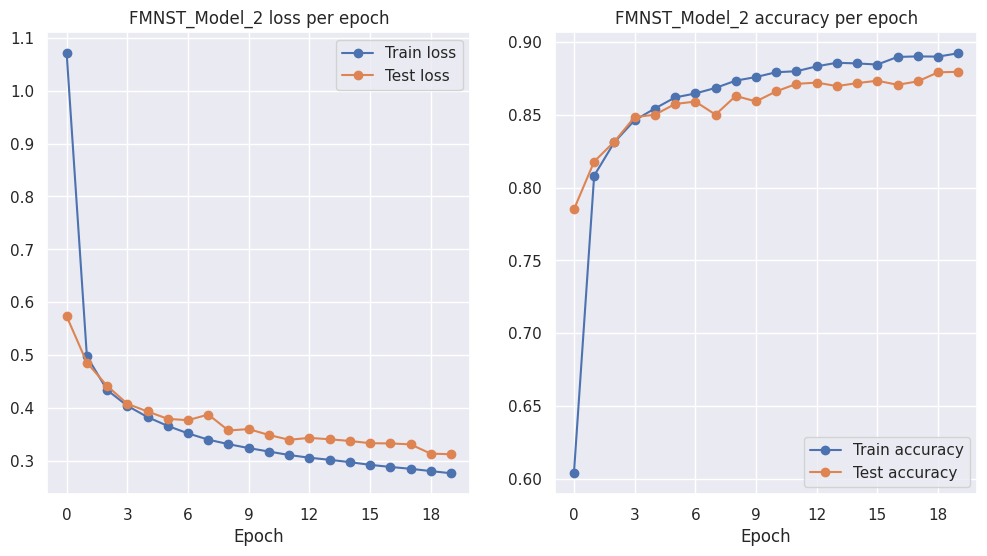

In [ ]:
plot_history(
    model_2_train_loss_history,
    model_2_train_acc_history,
    model_2_test_loss_history,
    model_2_test_acc_history,
    model_2
)

In [ ]:
model_2_eval_dct = eval_model(model=model_2, data_loader=test_dataloader, loss_fn=loss_fn, device=DEVICE, accuracy_fn=metric_fn)

## 5. Summarize the findings

### 5.1. Summarize gathered model performance information

In [ ]:
model_1_0_eval_dct['model_name'] = 'FMNST_Model_1_0'
model_1_1_eval_dct['model_name'] = 'FMNST_Model_1_1'

In [ ]:
models_overview_df = pd.DataFrame(
    [
        model_0_eval_dct,
        model_1_0_eval_dct,
        model_1_1_eval_dct,
        model_2_eval_dct
    ]
)

In [ ]:
models_overview_df

,model_name,model_loss,model_acc
0,FMNST_Model_0,0.439714,0.832773
1,FMNST_Model_1_0,0.978681,0.623954
2,FMNST_Model_1_1,0.820840,0.698043
3,FMNST_Model_2,0.313071,0.879580


In [ ]:
train_loss_hists = {
    'FMNST_Model_0': model_0_train_loss,
    'FMNST_Model_1_0': model_1_0_train_loss_history,
    'FMNST_Model_1_1': model_1_1_train_loss_history,
    'FMNST_Model_2': model_2_train_loss_history
}

train_acc_hists = {
    'FMNST_Model_0': model_0_train_acc,
    'FMNST_Model_1_0': model_1_0_train_acc_history,
    'FMNST_Model_1_1': model_1_1_train_acc_history,
    'FMNST_Model_2': model_2_train_acc_history
}

test_loss_hists = {
    'FMNST_Model_0': model_0_test_loss,
    'FMNST_Model_1_0': model_1_0_test_loss_history,
    'FMNST_Model_1_1': model_1_1_test_loss_history,
    'FMNST_Model_2': model_2_test_loss_history
}

test_acc_hists = {
    'FMNST_Model_0': model_0_test_acc,
    'FMNST_Model_1_0': model_1_0_test_acc_history,
    'FMNST_Model_1_1': model_1_1_test_acc_history,
    'FMNST_Model_2': model_2_test_acc_history
}

In [ ]:
list_of_colors = sns.color_palette(n_colors=4).as_hex()

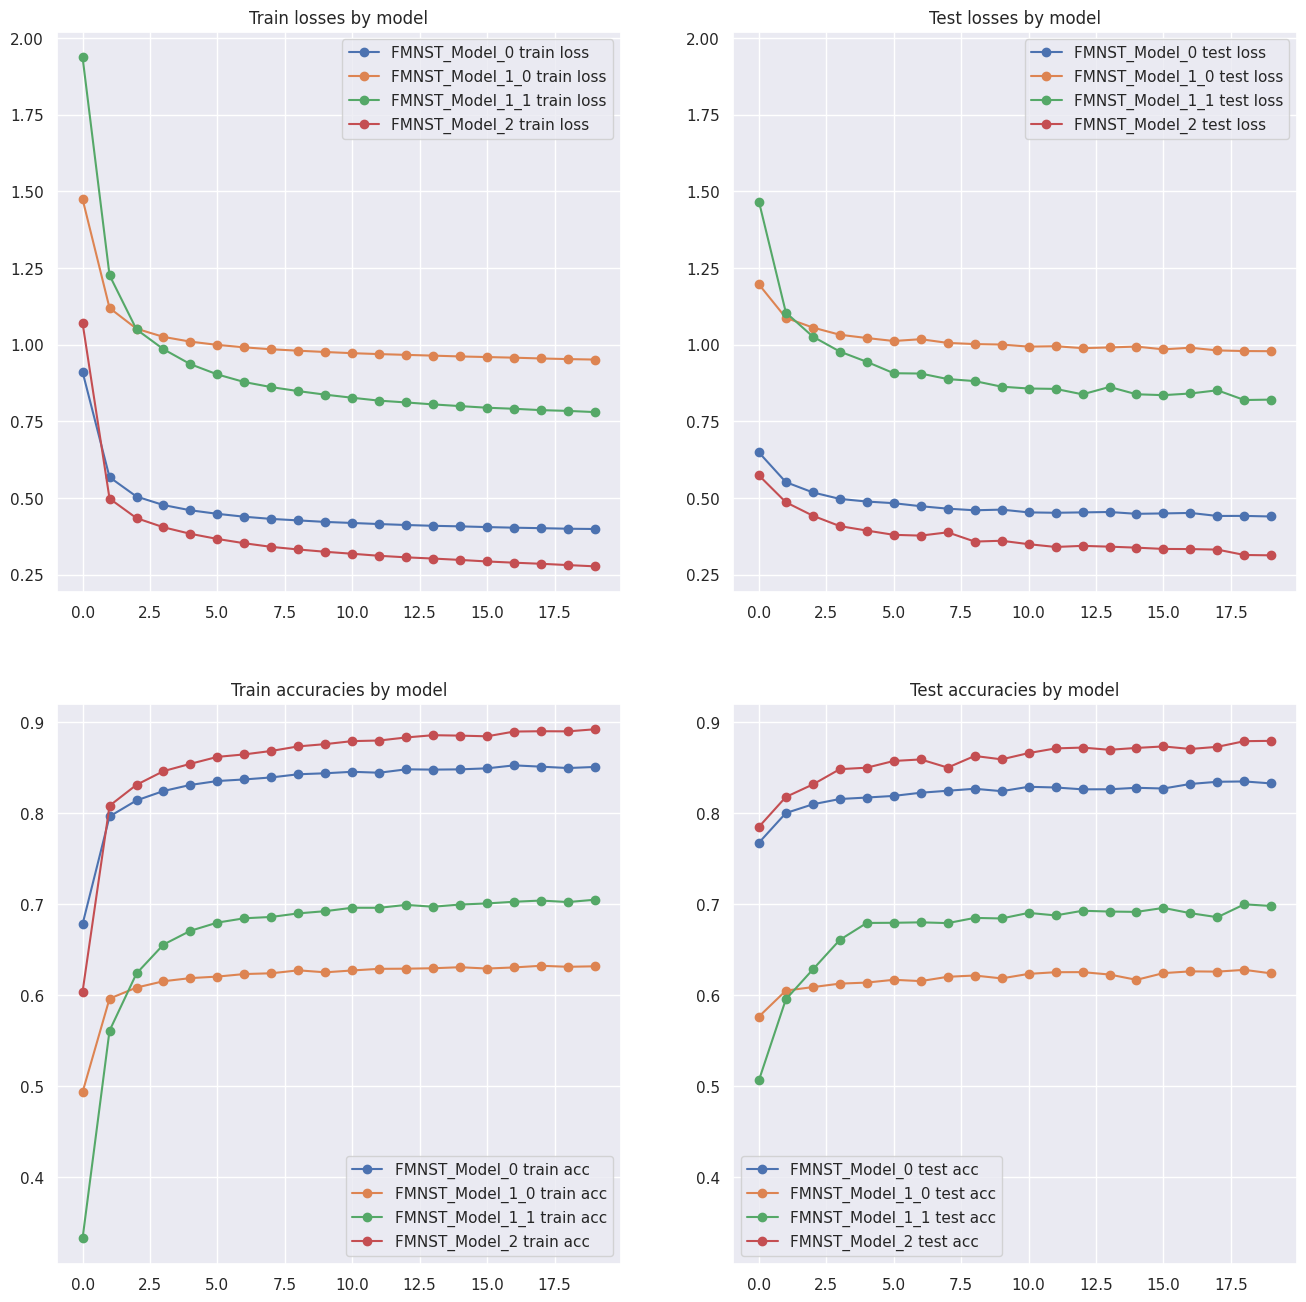

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(16, 16))

ax = axs[0, 0]
for idx, (key, value) in enumerate(train_loss_hists.items()):
  ax.plot(torch.Tensor(value).to('cpu').tolist(), label=f'{key} train loss', marker='o')
  ax.legend()
  ax.set_title('Train losses by model')

ax_prim = axs[0, 1]
ax_prim.sharey(ax)
for idx, (key, value) in enumerate(test_loss_hists.items()):
  ax_prim.plot(torch.Tensor(value).to('cpu').tolist(), label=f'{key} test loss', marker='o')
  ax_prim.legend()
  ax_prim.set_title('Test losses by model')

ax = axs[1, 0]
for idx, (key, value) in enumerate(train_acc_hists.items()):
  ax.plot(torch.Tensor(value).to('cpu').tolist(), label=f'{key} train acc', marker='o')
  ax.legend()
  ax.set_title('Train accuracies by model')

ax_prim = axs[1, 1]
ax_prim.sharey(ax)
for idx, (key, value) in enumerate(test_acc_hists.items()):
  ax_prim.plot(torch.Tensor(value).to('cpu').tolist(), label=f'{key} test acc', marker='o')
  ax_prim.legend()
  ax_prim.set_title('Test accuracies by model')


### 5.2. Extend by analysing category prediction performance using confusion matirces

In [ ]:
list_of_models = [model_0, model_1_0, model_1_1, model_2]
model_0_preds, model_1_0_preds, model_1_1_preds, model_2_preds = [], [], [], []

In [ ]:
list_of_preds = [model_0_preds, model_1_0_preds, model_1_1_preds, model_2_preds]

In [ ]:
for idx, model in enumerate(list_of_models):
  model.eval()
  with torch.inference_mode():
    for X, y in test_dataloader:
      X, y = X.to(DEVICE), y.to(DEVICE)

      y_logit = model(X)

      y_probs = torch.softmax(y_logit, dim=1)

      y_pred = torch.argmax(y_probs, dim=1)

      list_of_preds[idx].append(y_pred)

  list_of_preds[idx] = torch.cat(list_of_preds[idx])

In [ ]:
for x in list_of_preds:
  print(type(x))
  print(x)

<class 'torch.Tensor'>
tensor([9, 2, 1,  ..., 8, 1, 5])
<class 'torch.Tensor'>
tensor([9, 0, 1,  ..., 8, 1, 5])
<class 'torch.Tensor'>
tensor([9, 2, 1,  ..., 8, 1, 5])
<class 'torch.Tensor'>
tensor([9, 2, 1,  ..., 8, 1, 5])


In [ ]:
test_data.targets

tensor([9, 2, 1,  ..., 8, 1, 5])

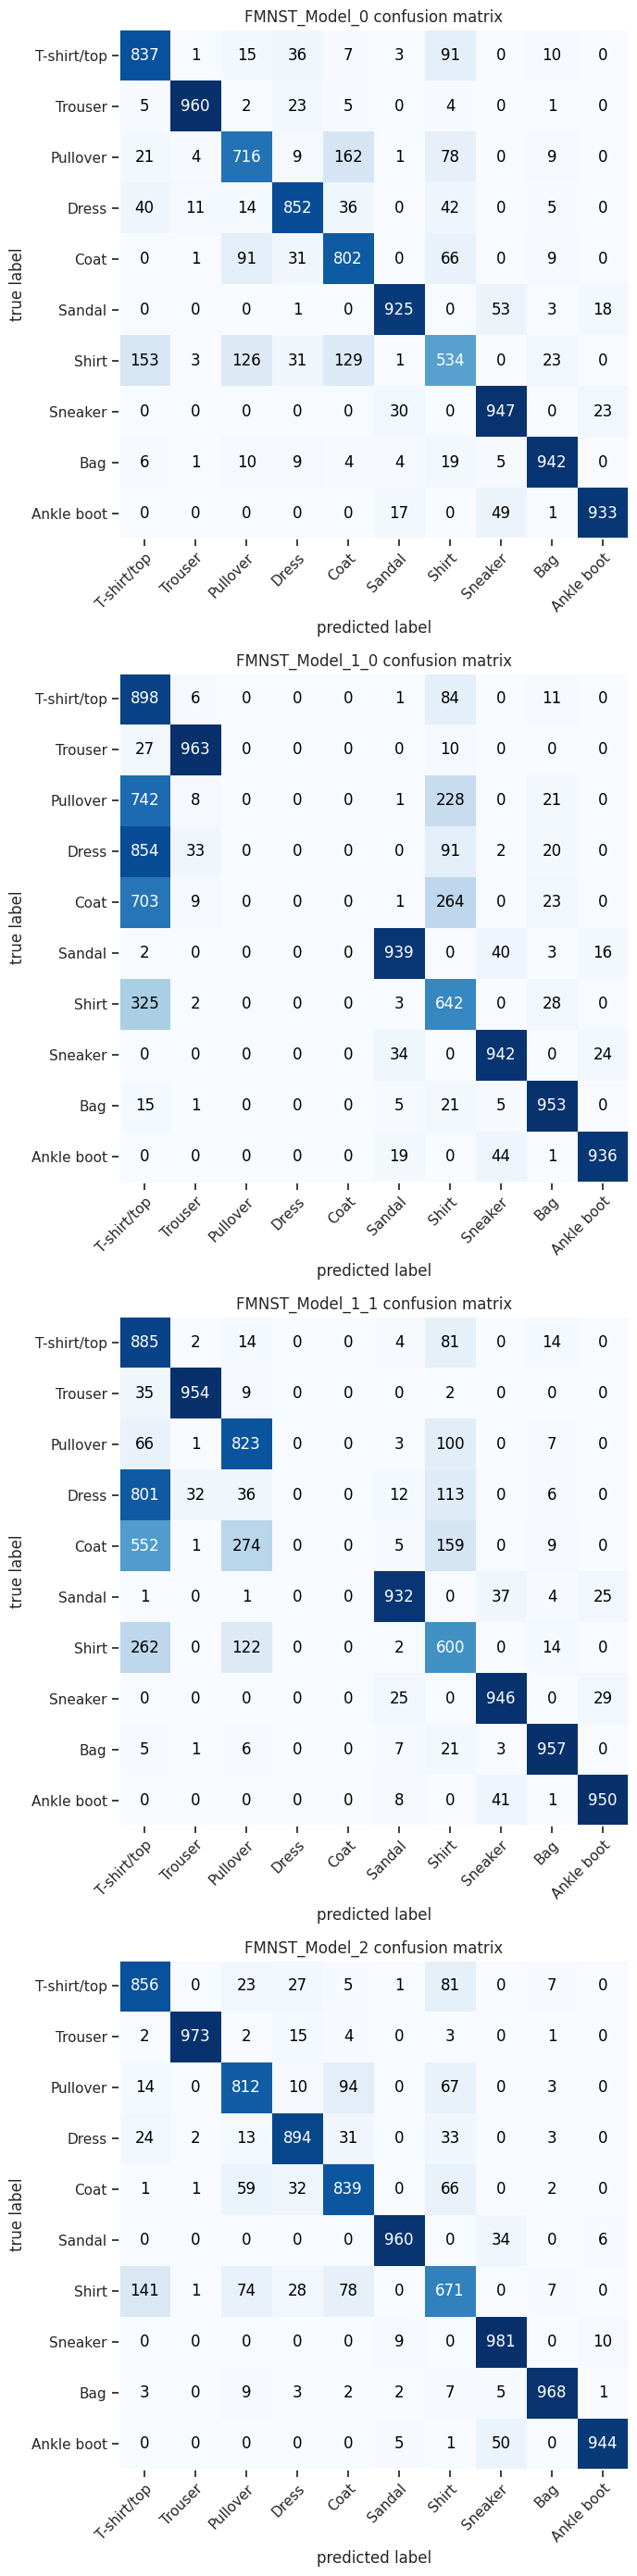

In [ ]:
fig = plt.figure(figsize=(10, 7*len(list_of_preds)))
for idx, pred_tensor in enumerate(list_of_preds):
  # Instantiate CM object
  conf_mat = ConfusionMatrix(
      num_classes=len(class_names),
      task='multiclass',
  )

  # Populate CM object
  conf_mat_tensor = conf_mat(
      preds = pred_tensor,
      target=test_data.targets
  )
  ax = fig.add_subplot(4, 1, idx+1)

  plot_confusion_matrix(
      conf_mat = conf_mat_tensor.numpy(),
      figure=fig,
      axis=ax,
      class_names=class_names,
  )

  ax.set_title(f'{list(train_acc_hists.keys())[idx]} confusion matrix')

plt.tight_layout()
plt.show()

---

Here, we see that Dense Neural Network with ReLU activations has problems with distinguishing shirts and t-shirt/tops from eachother and also dresses coat or pullovers.

It is noteworthy that the deeper DNN has lesser problem with that.

---